In [1]:
import math
import matplotlib.pyplot as plt
from collections import Counter
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

In [2]:
for dirname, _, filenames in os.walk('./data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

./data/test.csv
./data/graph.csv
./data/submission.csv
./data/train.csv


**Change the `data_dir` to the correct data set parent directory**

In [3]:
data_dir = "data"

In [4]:
train_data_path = os.path.join(data_dir, "train.csv")
test_data_path  = os.path.join(data_dir, "test.csv")
graph_data_path = os.path.join(data_dir, "graph.csv")

**Load data sheets to `pandas.DataFrame()`**

In [5]:
train_data = pd.read_csv(train_data_path)
train_data.describe()

,ID,Confirmed,Deaths,Recovered,Active,Incident_Rate,People_Tested,People_Hospitalized,Mortality_Rate,Testing_Rate,Hospitalization_Rate
count,7100.000000,7100.000000,7100.000000,5771.000000,7100.000000,7100.000000,7.100000e+03,5047.000000,7100.000000,7100.000000,5047.000000
mean,3549.500000,56374.339577,2323.883099,20422.274649,37635.120986,747.273790,6.427069e+05,6250.044185,3.653231,9666.099116,12.197144
std,2049.737788,95058.665054,4742.274729,39262.213465,79067.101832,637.397470,1.127555e+06,13880.694435,2.074042,7779.560336,5.255183
min,0.000000,270.000000,0.000000,0.000000,-989.000000,32.771004,5.459000e+03,10.000000,0.000000,460.300152,2.302896
25%,1774.750000,6097.500000,153.000000,1614.500000,2849.000000,224.815702,1.000775e+05,595.000000,1.928925,3379.288445,8.387037
50%,3549.500000,22892.000000,681.000000,5881.000000,10409.000000,540.836745,2.643235e+05,2068.000000,3.362027,7842.820591,11.351161
75%,5324.250000,62959.250000,2334.000000,26103.000000,32106.500000,1126.282666,7.048395e+05,6134.500000,4.797564,14127.521137,15.396088
max,7099.000000,712475.000000,32957.000000,507499.000000,699453.000000,3187.773001,1.137330e+07,89995.000000,9.741481,49502.860687,38.501190


## Now let's visualize some <br>S.H.I.T. (Scatterplots and Histograms that Interpret the Trend)

In [6]:
# First, we will get the total confirmed/deaths of each state
states = list(np.unique(train_data['Province_State']))
collected = ['Confirmed', 'Deaths', 'People_Tested']
states_data = dict.fromkeys(states, None)

for s in states:
    df_filter = train_data['Province_State'] == s
    state_df = train_data[df_filter]
    states_data[s] = state_df.drop(['Date','ID', 'Province_State', 'Recovered', 'People_Hospitalized', 'Hospitalization_Rate'], 1)
    save_columns = states_data[s].columns
    scaler = StandardScaler()
    states_data[s] = scaler.fit_transform(states_data[s])
    states_data[s] = pd.DataFrame(states_data[s], columns=save_columns)

In [7]:
states_data['California']

,Confirmed,Deaths,Active,Incident_Rate,People_Tested,Mortality_Rate,Testing_Rate
0,-1.126524,-1.568092,-1.119196,-1.126505,-1.202747,-0.105361,-1.202976
1,-1.121363,-1.546680,-1.114295,-1.121302,-1.202588,0.089968,-1.202815
2,-1.114888,-1.531345,-1.107963,-1.114775,-1.199327,0.135665,-1.199528
3,-1.108845,-1.504436,-1.102255,-1.108683,-1.195215,0.355231,-1.195384
4,-1.104343,-1.476658,-1.098125,-1.104144,-1.186602,0.612357,-1.186701
...,...,...,...,...,...,...,...
137,1.913187,1.914783,1.912677,1.913521,1.886294,-1.194190,1.886579
138,1.938467,1.951820,1.937763,1.938811,1.912848,-1.190039,1.913141
139,1.959608,1.977572,1.958825,1.959959,1.941352,-1.189475,1.941654
140,1.977387,1.990013,1.976684,1.977744,1.976538,-1.194020,1.976851


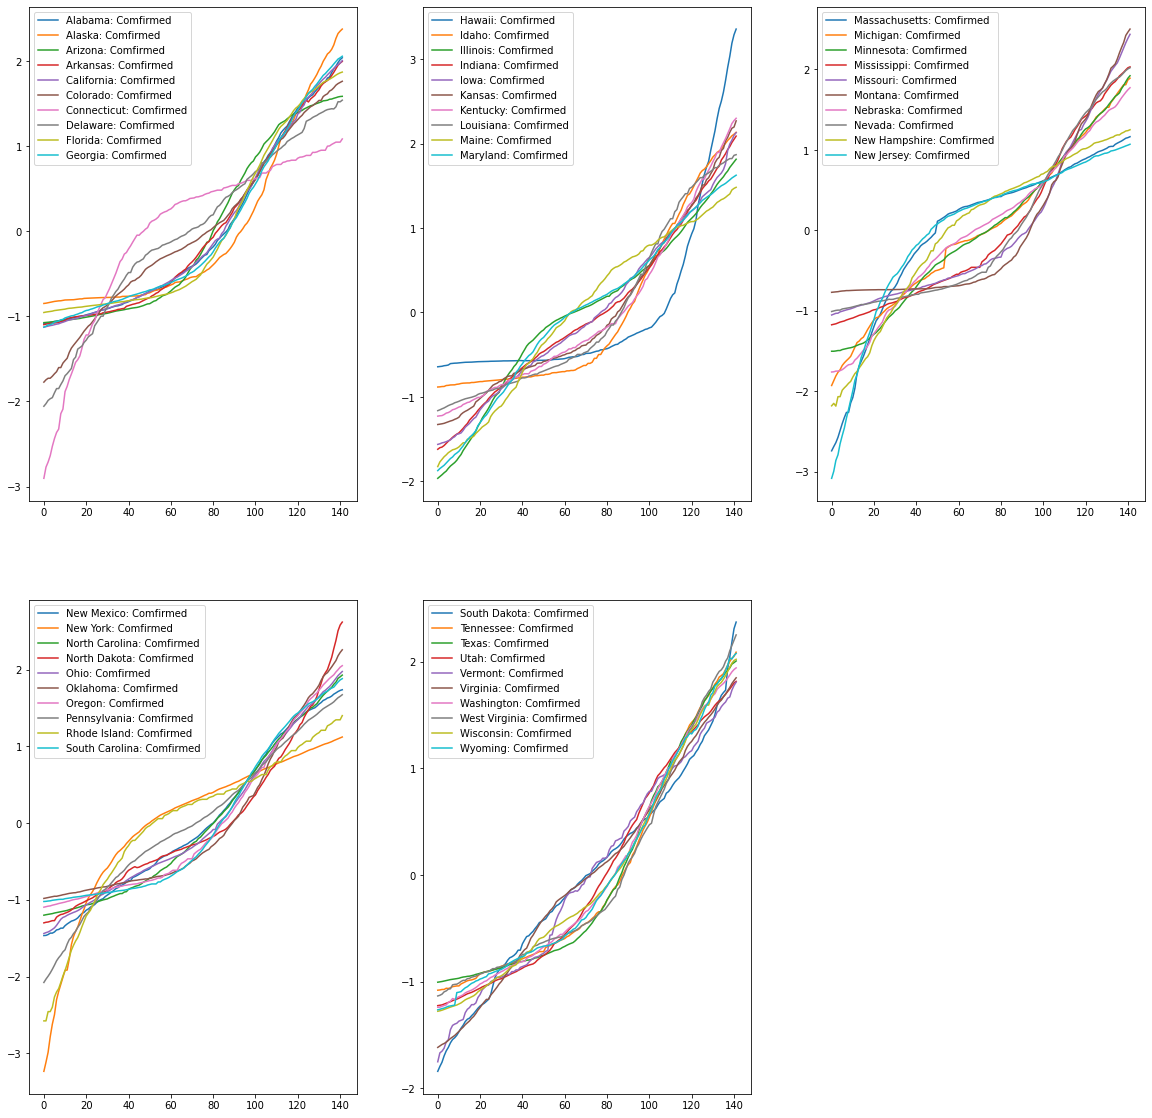

In [8]:
num_states = len(states_data.keys())
state_count = 1
figure_count = 1;
plt.figure(figsize=(20, 20))
for state in states_data.keys():
    if state_count == 1:
        plt.subplot(2,3,figure_count)
        plt.yscale('linear')
    plt.plot(states_data[state].Confirmed.values, label=f"{state}: Comfirmed")
    plt.legend(loc='best')
    state_count += 1
    if state_count == 11:
        state_count %= 10
        figure_count += 1
        
# plt.subplot(1,2,2)
# plt.plot(states_data['California'].Deaths.values, color='blue', label='Deaths')
# plt.legend(loc='best')


## Create Cross-validation Datasets

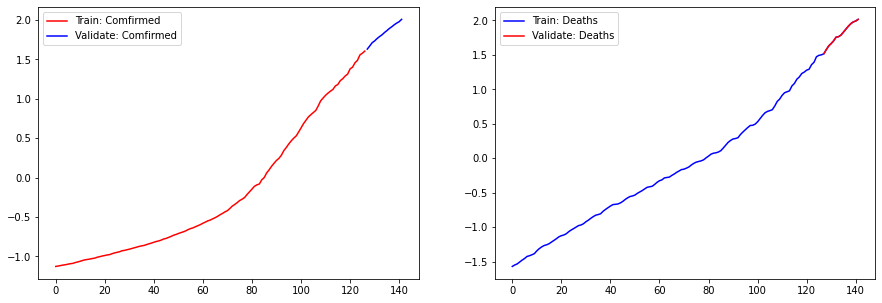

In [9]:
test_percentage = 0.9
validate_percentage = 0.1
state_train_data = {}
state_validate_data = {}

for state in states_data.keys():
    state_data_size = states_data[state].shape
    state_test_size = math.floor(state_data_size[0]*test_percentage)
    state_train_data[state] = states_data[state][:state_test_size]
    state_validate_data[state] = states_data[state][state_test_size:]

num_state_train = state_train_data['California'].shape[0]
num_state_validate = state_validate_data['California'].shape[0]
validate_range = np.arange(num_state_train, num_state_train+num_state_validate)

plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
plt.yscale('linear')
plt.plot(state_train_data['California'].Confirmed.values, color='red', label='Train: Comfirmed')
plt.plot(validate_range, state_validate_data['California'].Confirmed.values, color='blue', label='Validate: Comfirmed')
plt.legend(loc='best')
plt.subplot(1,2,2)
plt.plot(states_data['California'].Deaths.values, color='blue', label='Train: Deaths')
plt.plot(validate_range, state_validate_data['California'].Deaths.values, color='red', label='Validate: Deaths')
plt.legend(loc='best')

## Train a RNN Model with LSTM

In [27]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

# test model for CA
data_training = np.array(state_train_data['California'])

X_train = []
y_train = []

# window size 14
window_size = 14

for i in range(window_size, data_training.shape[0]):
    X_train.append(data_training[i-window_size:i])
    y_train.append(data_training[i, 0])
    
X_train, y_train = np.array(X_train), np.array(y_train)

In [28]:
model = keras.Sequential()

model.add(LSTM(units = 60, activation = 'relu', return_sequences = True, input_shape = (X_train.shape[1], 7)))
model.add(Dropout(0.2))

model.add(LSTM(units = 80, activation = 'relu', return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 120, activation = 'relu', return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 200, activation = 'relu'))
model.add(Dropout(0.2))

model.add(Dense(units = 1))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 14, 60)            16320     
_________________________________________________________________
dropout_4 (Dropout)          (None, 14, 60)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 14, 80)            45120     
_________________________________________________________________
dropout_5 (Dropout)          (None, 14, 80)            0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 14, 120)           96480     
_________________________________________________________________
dropout_6 (Dropout)          (None, 14, 120)           0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 200)              

In [29]:
model.compile(optimizer='adam', loss = 'mean_squared_error')
model.fit(X_train, y_train, epochs=100, batch_size=32)

Epoch 1/100
4/4 [==============================] - 0s 20ms/step - loss: 0.6417
Epoch 2/100
4/4 [==============================] - 0s 19ms/step - loss: 0.5037
Epoch 3/100
4/4 [==============================] - 0s 17ms/step - loss: 0.1682
Epoch 4/100
4/4 [==============================] - 0s 17ms/step - loss: 0.1070
Epoch 5/100
4/4 [==============================] - 0s 18ms/step - loss: 0.1195
Epoch 6/100
4/4 [==============================] - 0s 17ms/step - loss: 0.1164
Epoch 7/100
4/4 [==============================] - 0s 18ms/step - loss: 0.0619
Epoch 8/100
4/4 [==============================] - 0s 18ms/step - loss: 0.0332
Epoch 9/100
4/4 [==============================] - 0s 19ms/step - loss: 0.0342
Epoch 10/100
4/4 [==============================] - 0s 18ms/step - loss: 0.0130
Epoch 11/100
4/4 [==============================] - 0s 17ms/step - loss: 0.0167
Epoch 12/100
4/4 [==============================] - 0s 18ms/step - loss: 0.0137
Epoch 13/100
4/4 [==============================]

In [30]:
previous_days = state_train_data['California'].tail(window_size)
df = previous_days.append(state_validate_data['California'], ignore_index = True)

In [31]:
inputs = np.array(df)

In [32]:
X_test = []
y_test = []

for i in range(window_size, inputs.shape[0]):
    X_test.append(inputs[i-window_size:i])
    y_test.append(inputs[i,0])
    
X_test, y_test = np.array(X_test), np.array(y_test)

In [33]:
y_pred = model.predict(X_test)

In [34]:
y_result = y_pred.flatten().tolist()

In [35]:
y_result, y_test

([1.623908281326294,
  1.6599966287612915,
  1.6957827806472778,
  1.73380708694458,
  1.7719709873199463,
  1.811821699142456,
  1.8522223234176636,
  1.8935580253601074,
  1.9317551851272583,
  1.9697343111038208,
  2.005648612976074,
  2.041236400604248,
  2.0738682746887207,
  2.1067912578582764,
  2.139592170715332],
 array([1.62964643, 1.66928836, 1.71078858, 1.73347421, 1.76361116,
        1.78875937, 1.81077256, 1.83931021, 1.86416763, 1.89130134,
        1.91318732, 1.93846728, 1.95960813, 1.9773868 , 2.00702851]))

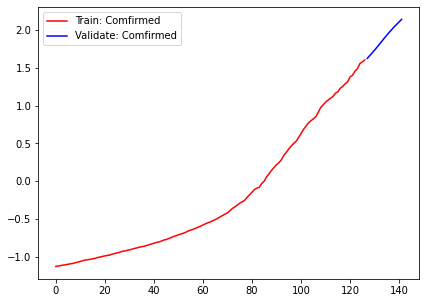

In [36]:
num_state_train = state_train_data['California'].shape[0]
num_state_validate = state_validate_data['California'].shape[0]
validate_range = np.arange(num_state_train, num_state_train+num_state_validate)

plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
plt.yscale('linear')
plt.plot(state_train_data['California'].Confirmed.values, color='red', label='Train: Comfirmed')
plt.plot(validate_range, y_result, color='blue', label='Validate: Comfirmed')
plt.legend(loc='best')